## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch
# !pip install torch torchvision torchaudio

# # Install additional dependencies
# !pip install matplotlib pandas pillow tqdm lxml

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import XML support
import xml.etree.ElementTree as ET

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,Datasets
Archive Directory:,Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'cvat-bounding-box-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/cvat-bounding-box-toy-dataset
Archive Path:,Datasets/../Archive/cvat-bounding-box-toy-dataset.zip
Dataset Path:,Datasets/cvat-bounding-box-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/cvat-bounding-box-toy-dataset/resolve/main/cvat-bounding-box-toy-dataset.zip


  0%|          | 0.00/16.1M [00:00<?, ?iB/s]

Extracting dataset...


### Getting the Image and Annotation Folders

In [6]:
 # Assuming the images are stored in a subfolder named 'default'
img_dir = dataset_path/'images/default'

# Assuming annotation file is in XML format and located in any subdirectory of the dataset
annotation_file_path = dataset_path/'annotations.xml'

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Image Folder": img_dir, 
    "Annotation File": annotation_file_path}).to_frame().style.hide(axis='columns')

Image Folder,Datasets/cvat-bounding-box-toy-dataset/images/default
Annotation File,Datasets/cvat-bounding-box-toy-dataset/annotations.xml


### Get Image File Paths

In [7]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem : file # Create a dictionary that maps file names to file paths
    for file in get_img_files(img_dir) # Get a list of image files in the image directory
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 28


,0
alcoholic-beverage-bar-beer-1269028,Datasets/cvat-bounding-box-toy-dataset/images/default/alcoholic-beverage-bar-beer-1269028.jpg
architectural-design-architecture-asphalt-2445783,Datasets/cvat-bounding-box-toy-dataset/images/default/architectural-design-architecture-asphalt-2445783.jpg
architecture-buildings-cars-1169374,Datasets/cvat-bounding-box-toy-dataset/images/default/architecture-buildings-cars-1169374.jpg
architecture-buildings-commerce-2308592,Datasets/cvat-bounding-box-toy-dataset/images/default/architecture-buildings-commerce-2308592.jpg
architecture-buildings-commuter-2516442,Datasets/cvat-bounding-box-toy-dataset/images/default/architecture-buildings-commuter-2516442.jpg


### Get Image Annotations

#### Define a function to parse the CVAT XML annotations

In [8]:
def parse_cvat_bbox_xml(xml_content):
    """
    Parse the given XML content of a CVAT bounding box annotation file and
    convert it into a pandas DataFrame.

    This function processes the XML content to extract information about each
    image and its associated bounding boxes. The data is then structured into
    a DataFrame for easier manipulation and analysis.

    Parameters:
    xml_content (str): A string containing the XML content from a CVAT bounding box
                       annotation file.

    Returns:
    pandas.DataFrame: A DataFrame where each row represents an image and contains
                      the following columns:
                      - Image ID (int): The unique identifier of the image.
                      - Image Name (str): The name of the image.
                      - Width (int): The width of the image in pixels.
                      - Height (int): The height of the image in pixels.
                      - Boxes (list): A list of dictionaries, where each dictionary
                                      represents a bounding box with keys 'Label',
                                      'xtl', 'ytl', 'xbr', and 'ybr' indicating the
                                      label and coordinates of the box.
    """

    # Parse the XML content
    root = ET.fromstring(xml_content)
    data = {}

    # Iterate through each image element in the XML
    for image in root.findall('image'):
        # Extract image attributes
        image_id = image.get('id')
        image_name = image.get('name')
        width = image.get('width')
        height = image.get('height')

        # Initialize a dictionary to store image data
        image_data = {
            'Image ID': int(image_id),
            'Image Name': image_name,
            'Width': int(width),
            'Height': int(height),
            'Boxes': []
        }

        # Iterate through each bounding box element within the image
        for box in image.findall('box'):
            # Extract box attributes
            label = box.get('label')
            xtl = float(box.get('xtl'))
            ytl = float(box.get('ytl'))
            xbr = float(box.get('xbr'))
            ybr = float(box.get('ybr'))

            # Construct a dictionary for the box data
            box_data = {
                'Label': label,
                'xtl': xtl,
                'ytl': ytl,
                'xbr': xbr,
                'ybr': ybr
            }

            # Append the box data to the image's 'Boxes' list
            image_data['Boxes'].append(box_data)

        # Map the image data to its ID in the data dictionary
        data[image_id] = image_data

    # Convert the data dictionary to a DataFrame and return
    return pd.DataFrame.from_dict(data, orient='index')

#### Load CVAT XML annotations into a DataFrame

In [9]:
# Read the XML file
with open(annotation_file_path, 'r', encoding='utf-8') as file:
    xml_content = file.read()

# Parse the XML content
annotation_df = parse_cvat_bbox_xml(xml_content)

# Add a new column 'Image ID' by extracting it from 'Image Name'
# This assumes that the 'Image ID' is the part of the 'Image Name' before the first period
annotation_df['Image ID'] = annotation_df['Image Name'].apply(lambda x: x.split('.')[0])

# Set the new 'Image ID' column as the index of the DataFrame
annotation_df = annotation_df.set_index('Image ID')

# Display the first few rows of the DataFrame
annotation_df.head()

,Image Name,Width,Height,Boxes
Image ID,,,,
258421,258421.jpg,768,1152,"[{'Label': 'person', 'xtl': 386.08, 'ytl': 443.94, 'xbr': 460.82, 'ybr': 777.16}, {'Label': 'person', 'xtl': 340.25, 'ytl': 466.94, 'xbr': 418.99, 'ybr': 777.34}]"
3075367,3075367.jpg,1344,768,"[{'Label': 'person', 'xtl': 413.32, 'ytl': 41.22, 'xbr': 919.81, 'ybr': 763.17}]"
3076319,3076319.jpg,768,1120,"[{'Label': 'person', 'xtl': 335.31, 'ytl': 151.75, 'xbr': 711.22, 'ybr': 1117.49}, {'Label': 'person', 'xtl': 8.11, 'ytl': 131.88, 'xbr': 404.2, 'ybr': 1119.0}]"
3145551,3145551.jpg,1184,768,"[{'Label': 'person', 'xtl': 642.0, 'ytl': 289.85, 'xbr': 669.66, 'ybr': 398.89}, {'Label': 'person', 'xtl': 658.63, 'ytl': 281.25, 'xbr': 687.09, 'ybr': 398.61}]"
3176048,3176048.jpg,1152,768,"[{'Label': 'person', 'xtl': 518.23, 'ytl': 338.97, 'xbr': 594.63, 'ybr': 466.08}, {'Label': 'person', 'xtl': 683.42, 'ytl': 356.48, 'xbr': 638.86, 'ybr': 437.82}]"


### Inspecting the Class Distribution

#### Get image classes

In [10]:
# Explode the 'boxes_df' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'boxes_df' column to 'boxes_df'
# Apply the pandas Series function to the 'boxes_df' column of the dataframe
boxes_df = annotation_df['Boxes'].explode().to_frame().Boxes.apply(pd.Series)

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = boxes_df['Label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,person


#### Visualize the class distribution

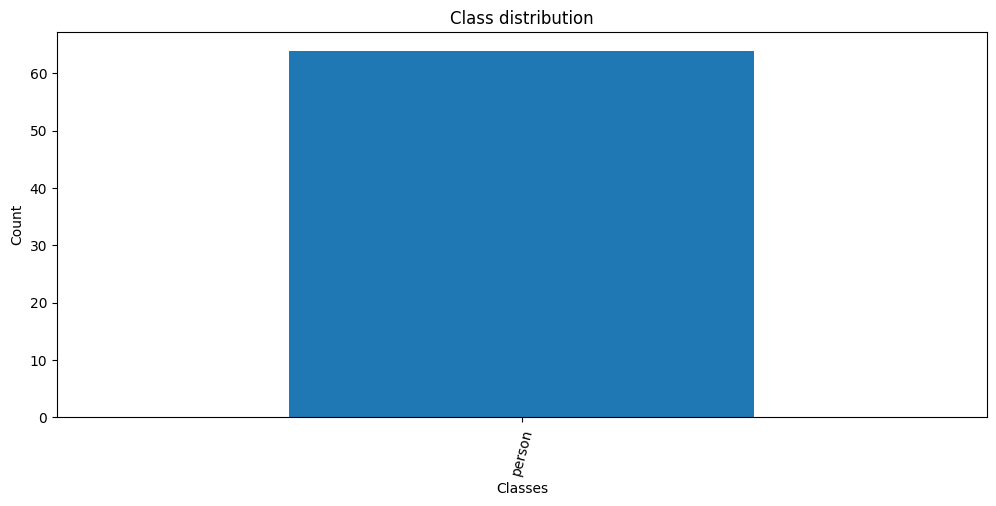

In [11]:
# Get the number of samples for each object class
class_counts = boxes_df['Label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar', figsize=(12, 5))
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_counts.index, rotation=75)  # Set the x-axis tick labels
plt.show()

### Visualizing Keypoint Annotations

#### Generate a color map

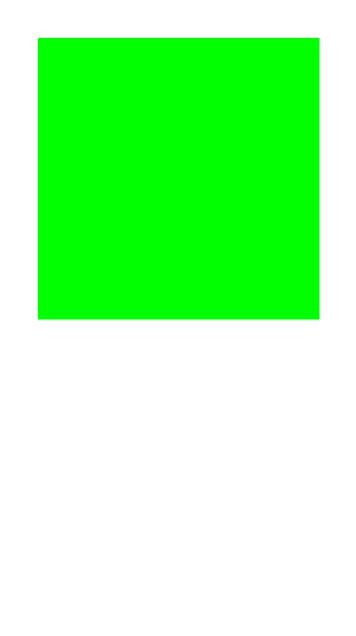

In [12]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [13]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [14]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (1120, 768)


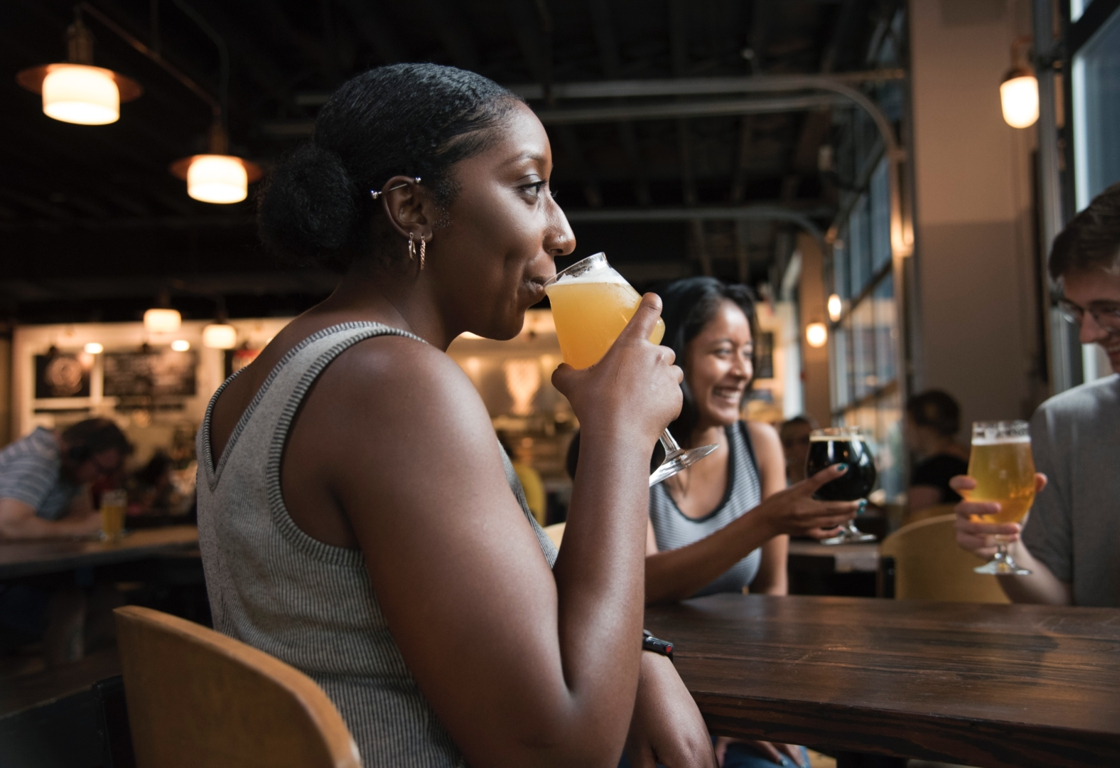

In [15]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [16]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,alcoholic-beverage-bar-beer-1269028
Image Name,alcoholic-beverage-bar-beer-1269028.jpg
Width,1120
Height,768
Boxes,"[{'Label': 'person', 'xtl': 567.93, 'ytl': 278.21, 'xbr': 868.54, 'ybr': 595.28}, {'Label': 'person', 'xtl': 191.38, 'ytl': 59.88, 'xbr': 720.16, 'ybr': 763.25}, {'Label': 'person', 'xtl': 947.8, 'ytl': 178.82, 'xbr': 1119.0, 'ybr': 607.11}]"


#### Annotate sample image

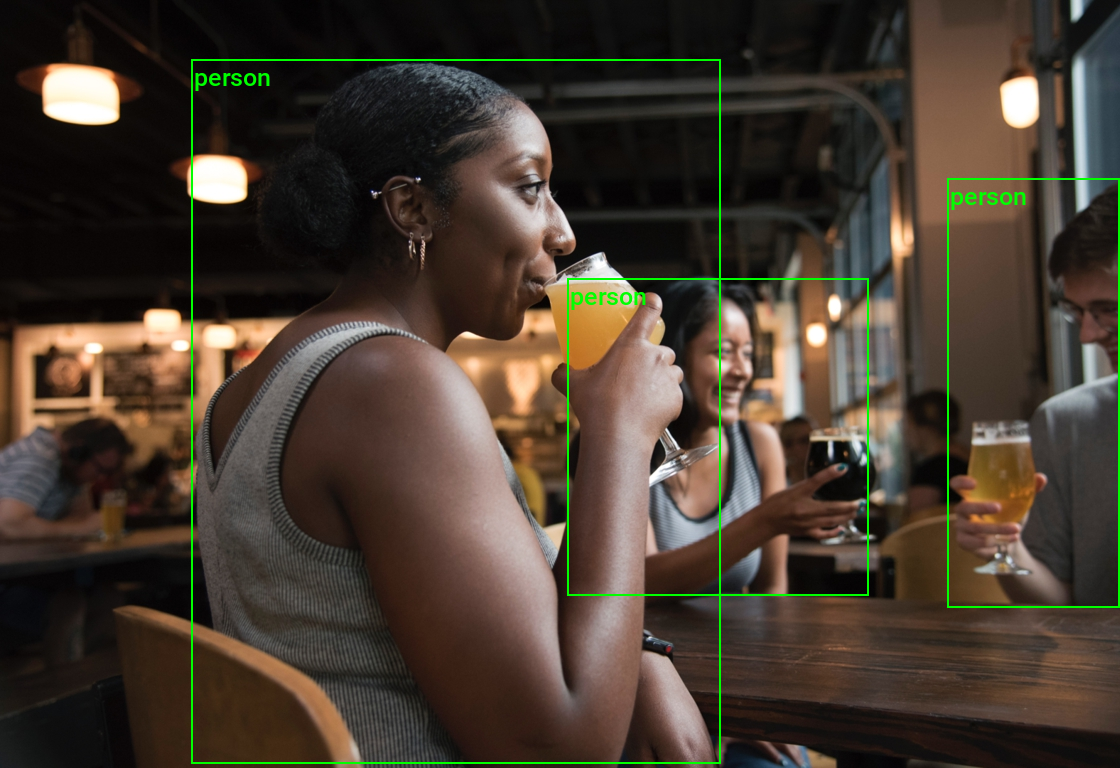

In [17]:
# Extract the labels and bounding box annotations for the sample image
labels = [box['Label'] for box in annotation_df.loc[file_id]['Boxes']]
bboxes = np.array([[box['xtl'], box['ytl'], box['xbr'], box['ybr']] for box in annotation_df.loc[file_id]['Boxes']]).reshape(len(labels),4)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=BoundingBoxes(torch.Tensor(bboxes), format='xyxy', canvas_size=sample_img.size[::-1]),
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Data Augmentation

#### Set training image size

In [18]:
# Set training image size
train_sz = 384

#### Initialize custom transforms

In [19]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

#### Test the transforms

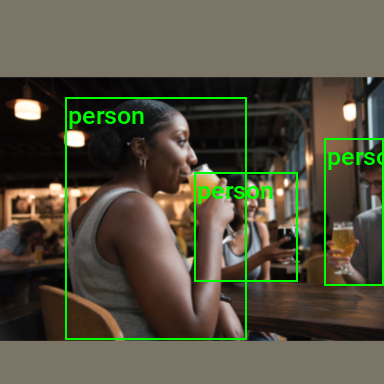

Source Image:,"(1120, 768)"
Cropped Image:,"(1120, 768)"
Resized Image:,"(383, 263)"
Padded Image:,"(383, 383)"
Resized Padded Image:,"(384, 384)"


In [20]:
# Prepare bounding box targets
targets = {'boxes': BoundingBoxes(torch.Tensor(bboxes), 
                                format='xyxy', 
                                canvas_size=sample_img.size[::-1]), 
           'labels': labels}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(resized_padded_img), 
    boxes=targets['boxes'], 
    labels=targets['labels'], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [21]:
class CVATBBoxDataset(Dataset):
    """
    A custom dataset class for handling bounding box annotations from CVAT.

    This dataset class is designed to work with bounding box annotations exported
    from the CVAT annotation tool. It allows for loading images and their corresponding
    bounding box annotations for use in training machine learning models.

    Attributes:
        _img_keys (list): A list of image keys.
        _annotation_df (pandas.DataFrame): A DataFrame containing annotations.
        _img_dict (dict): A dictionary mapping image keys to image file paths.
        _class_to_idx (dict): A dictionary mapping class names to class indices.
        _transforms (callable, optional): A function/transform that takes in an image
            and a target, and returns a transformed version.

    Args:
        img_keys (list): List of image keys.
        annotation_df (pandas.DataFrame): DataFrame containing annotations.
        img_dict (dict): Dictionary mapping image keys to image paths.
        class_to_idx (dict): Dictionary mapping class names to class indices.
        transforms (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        super(Dataset, self).__init__()

        self._img_keys = img_keys
        self._annotation_df = annotation_df
        self._img_dict = img_dict
        self._class_to_idx = class_to_idx
        self._transforms = transforms

    def __len__(self):
        """
        Returns the total number of items in the dataset.

        Returns:
            int: Total number of items.
        """
        return len(self._img_keys)

    def __getitem__(self, index):
        """
        Retrieves an image and its associated target (bounding boxes and labels) at the specified index.

        Args:
            index (int): The index of the item.

        Returns:
            tuple: A tuple containing an image and its corresponding target.
        """
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)
        
        if self._transforms:
            image, target = self._transforms(image, target)

        return image, target

    def _load_image_and_target(self, annotation):
        """
        Loads an image and its corresponding target data (bounding boxes and labels) based on the provided annotation.

        Args:
            annotation (pandas.Series): The annotation data for a specific image.

        Returns:
            tuple: A tuple containing the image and a dictionary with 'boxes' and 'labels'.
        """
        # Retrieve the file path from the image dictionary using the annotation's name as the key.
        filepath = self._img_dict[annotation.name]

        # Open the image file and convert it to RGB.
        image = Image.open(filepath).convert('RGB')

        # Extract bounding box coordinates from the annotation and convert them to a numpy array.
        bbox_list = np.array([[box['xtl'], box['ytl'], box['xbr'], box['ybr']] for box in annotation['Boxes']]).reshape(len(annotation['Boxes']), 4)

        # Convert the numpy array of bounding boxes to a PyTorch tensor.
        bbox_tensor = torch.Tensor(bbox_list)

        # Create bounding box objects with the tensor, specifying the format and canvas size.
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])

        # Extract labels from the annotation and map them to their corresponding indices.
        annotation_labels = [box['Label'] for box in annotation['Boxes']]
        labels = torch.Tensor([self._class_to_idx[label] for label in annotation_labels])

        # Return the image and a dictionary containing the bounding boxes and labels.
        return image, {'boxes': boxes, 'labels': labels}

### Image Transforms

In [22]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

### Initialize Dataset

In [23]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = CVATBBoxDataset(list(img_dict.keys()), annotation_df, img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

Training dataset size:,28


### Inspect Samples

**Inspect training set sample**

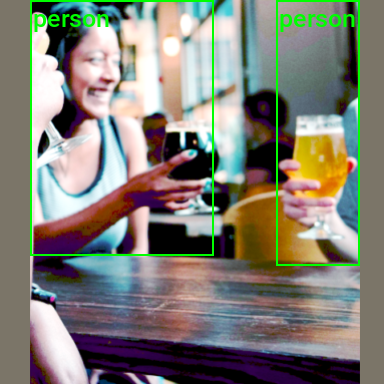

In [24]:
dataset_sample = train_dataset[0]

annotated_tensor = draw_bboxes(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)